(sec:introduction_to_bayesian_inference)=

# Introduction to Bayesian Inference

In this section, I want to illustrate some basic ideas of "classification." It will help us to understand some of the notation and some of the general concepts used throughout this document. It will illustrate the role of priors, the problem of classification in the context of imbalanced classes, and how to estimate classification performance correctly. Finally, it will also describe and provide some of the most important tools we will use for the data and statistical analysis. 

(example:screening_for_asd_headturn)= 

## Example: Screening for Autism Spectrum Disorder
Let us start with an example. Assume we have the task of determining whether a child has Autism Spectrum Disorder (ASD), and we have available, only one clinical measure "x." 

```{admonition} Notation
The universe of subjects/samples will be noted as $\mathcal{U}$, for each subject $s_i\in\mathcal{U}$, its ground truth label is represented by $y_i$, in this example we associate the value $y=1$ with the ASD group (and $0$ otherwise). The feature $X$ is a measure we will use for classification/prediction, $x_i$ represent the value of the feature for the subject $s_i$. 
```

An example of feature is the delay on head-turning after a name call.{cite}`campbell2019computer` For example, given a subject $s_i$, we are provided with a value $x_i$ that corresponds to the subjects' delay in seconds after his/her name is called. Given this information, we want to infer what is the probability that the child has ASD or not ($y_i=1$ or $y_i=0$). Let's build a numerical example.

```{Caution}
All the number and experiments here presented are made up. This document focuses on the mathematical tools, and is not intended to present or analyze any real data nor extract real behavioral conclusion. 
```

In [1]:
# import pre-installed packages and init. 
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys 
from myst_nb import glue

# add tools path and import our own tools
sys.path.insert(0, '../tools')
%load_ext autoreload
%autoreload 2
mpl.rcParams.update({'font.size': 14})

In [2]:
# Let us create some toy data:
from create_data import create_headturn_toy_example
X_u, Y_u = create_headturn_toy_example(num_points=1e5, prop_positive=0.05)
X, Y = create_headturn_toy_example(num_points=1e3, prop_positive=0.2)

`X_u` and `Y_u` denote the set of $x$ and $y$ values for the subjects in our universe $\mathcal{U}$. We simulated that there are $10k$ kids in our target population $\mathcal{U}$. On the other hand, `X` and `Y` represent a dataset we have available, i.e., the kids that came to the clinic. The main objective is to use our sample $(X,Y)$ to develop and evaluate tools that work on our target population with data $(X_u,Y_u)$.   

**The priors might vary between the target population and the set available.** In this experiment, we model that 5% of the kids in $\mathcal{U}$ have ASD. In our sample $(X,Y)$ on the other hand, we simulated a larger proportion of ASD children: 20%. This means that for the data we have available, we have four times more chances of sampling an ASD child if we select a child at random. Overrepresenting the minority class when empirical data is collected is a common and reasonable practice. We want to learn key features that represent both classes, and we need a considerable number of samples from both categories. Sampling at random from $\mathcal{U}$ would be very inefficient in terms of getting samples from the minority class (since we are considering imbalanced problems). Instead, we can work with a set that over-represents the minority class and correct the metrics, so the performance matches the prior in the actual population, as we discuss in the following. ADDREF

## Identifying and assessing descriptive features. 
Let's start to look into the data and try to get some idea about the following questions: **Q1: Is the head turn delay a useful feature for the diagnosis of ASD? If the answer is "Yes," Q2: how reliable this biomarker is?**

To answer the previous questions, we can start by looking at the data we have available $(X,Y)$:

/Users/matiasdimartino/miniconda3/envs/stats/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/matiasdimartino/miniconda3/envs/stats/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


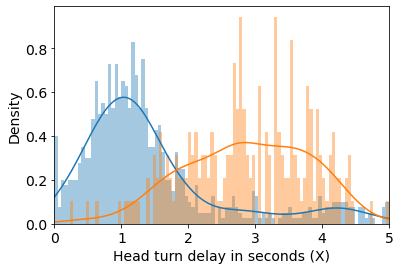

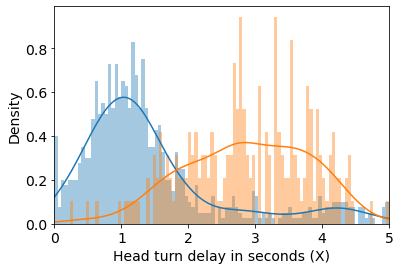

In [3]:
# Compute and plot the histogram of X values for each clas. 
df = pd.DataFrame({'X':X,'Y':Y}); 
fig = plt.figure()
sns.distplot(df.query('Y==0')['X'],bins=100, kde=True); 
sns.distplot(df.query('Y==1')['X'],bins=100, kde=True); 
plt.xlabel('Head turn delay in seconds (X)'); plt.xlim([0,5]);

glue("hist_head_turn_lab", fig, display=False)

```{glue:figure} hist_head_turn_lab
:figwidth: 50%
:name: "fig:hist_head_turn_lab"

Distribution of the head turn values on the sample data (X,Y). The blue and orange distributions represent the histogram across the non-ASD and ASD groups respectively, (P(X|Y)).
```

Looking at the results of {numref}`fig:hist_head_turn_lab`, the answer to Q1 seems to be YES! Head-turn delay looks like a descriptive biomarker for autism (recall this is just simulated data and a toy example). For the moment, we are answering the question informally, just by looking at the blue and orange distributions and observing that _they look different_. Of course a more formal statistical approach can be adopted, which is the subject of Section {ref}`sec:hypothesis_testing`.  

This toy data suggests that kids in the non-ASD group are turning their heads faster after a name call. It also looks that if the delay is below one second, we are almost certain the kid belongs to the non-ASD group. At the same time, for values larger than 2s, there is a higher chance for the kid to be on the ASD group. Finally, if $x_i\approx 2$ we do not have much information about whether the subject $s_i$ is in one group or the other. According to these observations, answering Q2:how accurate is this feature? Is not trivial, the first answer seems to be: "it depends where in this distributions you fall." We will address this formally in section {ref}`subsec:posterior_odds`.  

## The importance of priors on imbalance problems

The distributions shown in {numref}`fig:hist_head_turn_lab` can be miss-leading, since they only illustrate the distribution of the feature ($X$) withing the classes (i.e., $P(X|y=0)$ and $P(X|y=1)$), but they do not take into account that the occurrence of one of the classes is much more frequent than the other (i.e., $p(y=1) \ll p(y=0)$). 
For example, one might wrongly conclude that if a child has a delay of 3 seconds on responding to the name call, then he/she has _more chances_ of being in the ASD group compared to the non-ASD group. More precisely, what we need to estimate is the probability of $y=1$ given that we observed $x=3s$, formally, $P(Y|X)$ (not $P(X|Y)$!). We can achieve this using Bayes Theorem {cite}`duda2012pattern` {cite}`wasserman2013all`:

$$
P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}.
$$ (eq:bayes_theorem)



/Users/matiasdimartino/miniconda3/envs/stats/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/matiasdimartino/miniconda3/envs/stats/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


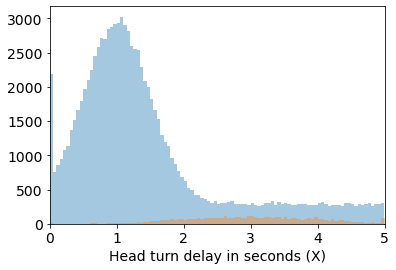

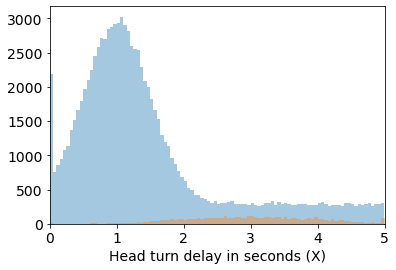

In [4]:
df = pd.DataFrame({'X':X_u,'Y':Y_u}); 
fig = plt.figure()
sns.distplot(df.query('Y==0')['X'],bins=100, kde=False); 
sns.distplot(df.query('Y==1')['X'],bins=100, kde=False); 
plt.xlim([0,5]); plt.xlabel('Head turn delay in seconds (X)');
glue("hist_with_prior_head_turn_lab", fig, display=False)

```{glue:figure} hist_with_prior_head_turn_lab
:figwidth: 50%
:name: "fig:hist_with_prior_head_turn_lab"

Distribution of the head turn values on the sample data (X,Y) including the classes prior. 
The blue and orange distributions represent the absolute number of samples for each X value withing the non-ASD and ASD groups: (P(X|Y)P(Y)).
```

{numref}`fig:hist_with_prior_head_turn_lab` shows the distributions $P(X|Y)P(Y)$ which take into account the important prior factor $P(Y)$. Compare for example {numref}`fig:hist_head_turn_lab` and {numref}`fig:hist_with_prior_head_turn_lab`, and notice how even if a child presents a delay of 3 seconds in responding ($X=3s$) is still more likely that he/she is in the non-ASD group. Even though $P(X=3|y=1)>P(X=3|y=0)$, we have that $P(X=3|y=1)P(y=1)<P(X=3|y=0)P(y=0)$. A practical solution to properly asses risk factors, is to consider the {ref}`posterior probability odds <subsec:posterior_odds>`. 

(subsec:posterior_odds)=

## Posterior odds

A significant imbalance between the frequency of the classes poses several challenges, in particular, on how to measure performance (we will discuss performance measures in Section {ref}`subsec:performance_measures`). To illustrate this issue, ASD has a prevalence under $5\%$, which means that if we always assume a child is TD, we will be right more than $95\%$ of the time, though we are not helping a single child with ASD. 

In the previous sections, we discussed the importance of priors and formalized ideas in the framework of Bayesian inference. It follows naturally that a way of assessing the likelihood of a class is to compare how much more likely is $Y=1$ than $Y=0$ given $X=x$. Formally, 

$$
\frac{P(Y=1|X)}{P(Y=0|X)} = \frac{P(X|Y=1)P(Y=1)}{P(X|Y=0)P(Y=0)},
$$ (posteriorodds)

where the equality follows from Bayes theorem. 

For example, $\frac{P(Y=1|X)}{P(Y=0|X)}=2$ means that given the value of X, the probability of the subject to be in the ASD group is twice the probability of being in the TD group. Notice that when "X" has no information about "Y" (i.e., we measure a useless feature)

$$
\frac{P(Y=1|X)}{P(Y=0|X)} \rightarrow \frac{P(Y=1)}{P(Y=0)}.
$$

The term $P(Y|X)$ is named as the posterior probability, and therefore the fraction $\frac{P(Y=1|X)}{P(Y=0|X)}$ is referred to as the posterior odds. Though this quantity has an intuitive meaning (how many times more likely one class is than the other), it does not account for the imbalance between the classes. To incorporate this information, we can compare the posterior odds with the prior odds, using the latter as a form of normalization:

$$
\frac{\frac{P(Y=1|X)}{P(Y=0|X)}}{\frac{P(Y=1)}{P(Y=0)}} = \frac{P(X|Y=1)}{P(X|Y=0)}.
$$ (posteriorodds_normalized)

Equation {eq}`posteriorodds_normalized` shows that the normalized posterior odds can be computed from the conditional distributions $P(X|Y)$, which has a very practical impact. 


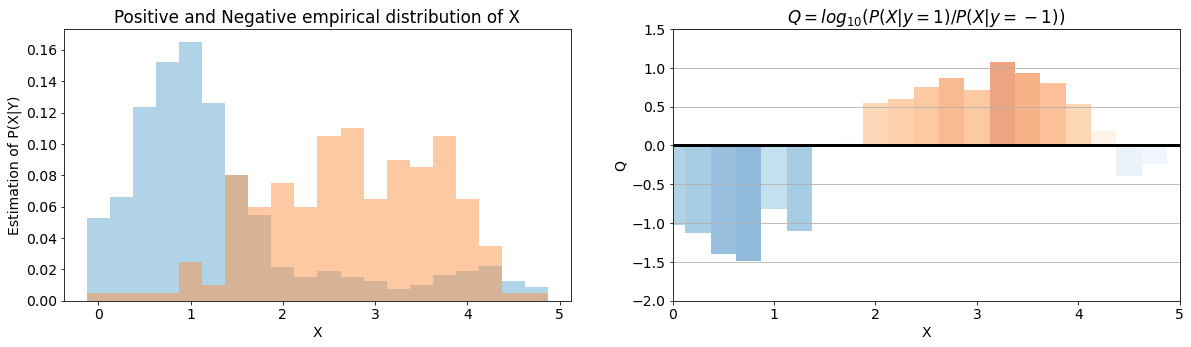

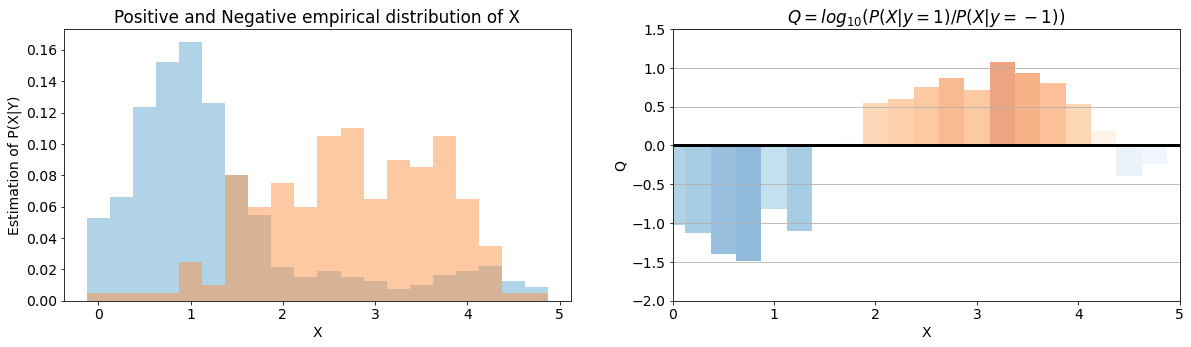

In [5]:
from stats import feature_values_positive_to_negative_ratio
Xp = X[Y==1]; Xn = X[Y==0]
fig = plt.figure(figsize=[20,5]); 
Q = feature_values_positive_to_negative_ratio(Xp=Xp, Xn=Xn, verbose=1, num_bins=20)
glue("posterior_odds_normalized", fig, display=False)

```{glue:figure} posterior_odds_normalized
:figwidth: 100%
:name: "fig:posterior_odds_normalized"

Left: Distribution of the feature X for each class (P(X|Y)). Right: normalized posterior odds in logarithmic scale. 
```

(subsec:performance_measures)=
## Performance measures for imbalance problems

Let assume after analysis, we decide we will predict ASD versus non-ASD labels depending on the kid's head turn delay after a name call. For example, we can define $\hat{y} \stackrel{def}{=} x>2$, this is, $\hat{y}=1$ for all the kids which response is slower than two seconds, and $\hat{y} = 0$ for all the kids which response is faster or equal than two seconds. Recall that for each participant we have their ground truth label $y=1$ if they are in the ASD group, $y=0$ if they are in the non-ASD group. 

Four quantities fully describe the performance of a classification algorithm: number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN). The TP is define as the number of subject for which $y=1$ and $\hat{y}=1$, TN the number of subject for which $y=0$ and $\hat{y}=0$, FP the number of subject for which $y=0$ and $\hat{y}=1$ and finally, FN the number of subjects for which $y=1$ and $\hat{y}=0$. 

Some useful metrics for the evaluation of classifiers are: Accuracy $\frac{TP+TN}{TP+TN+FP+FN}$, others? As we discussed earlier, measures such as the accuracy are not suited for imbalance problems. Instead, appropriate metrics are: recall $\frac{TP}{TP+FN}$ (a.k.a sensitivity, true positive rate), precision $\frac{TP}{TP+FP}$ (a.k.a. positive predictive value), f-value (which is a weighted average between recall and precision), true negative rate $\frac{TN}{TN+FP}$, or false positive rate $\frac{FP}{FP+TN}$. Another family of metrics provides information about a "family" of solutions rather than the performance on particular operation points. For example, the ROC curve shows the false positive rate (horizontal axis) versus the true positive rate (vertical axis). It is important to notice that the ROC curve does not provide the performance of a particular implementation. (There is no particular fixed labels nor fixed values for the TP, TN, FP, and FN). Instead, it shows a "family" of solutions when one hyper-parameter (typically a classification threshold) varies. To overcome this limitation, measures such as the area under the roc curve (AUC) have been proposed.

```{Caution} If the proportion of positive and negative samples in the dataset is different from the ratio in the entire population (which in general happens in the clinic), some of the measures listed above will be skewed. To have an accurate performance estimation, this issue should analyzed. 
```

### Summary

We discussed the role of priors, and why measuring "detection" in problems with imbalance classes is not trivial. We discussed how Bayes's ideas provide a possible framework to formalize and explain these concepts. We showed that it is essential to add to the extracted features, confidence measures with a probabilist and interpretable meaning. 

So far, we assumed we could approximate $P(X|Y)$ by measuring the "histogram" of the observed values of $X$ over an empirical sample. Section {ref}`sec:pdf_estimation` formalizes this concept and discusses how to calculate the estimation error and confidence intervals.